# The Daubechies D4 Wavelet Tranform

In [19]:
import numpy as np
import cv2
import IPython
from PIL import Image
import matplotlib.pyplot as plt
from time import time
from scipy.sparse import csr_matrix

def obtener_matriz_recortada(matriz, escala):
    n = matriz.shape[0]
    m = n // (2**escala)
    matriz_recortada = matriz[:m, :m]
    return matriz_recortada


def split_matrix(mat): # divide the matrix into 4 quadrants
    h, w = mat.shape
    return mat[:h // 2, :w // 2], mat[:h // 2, w // 2:], mat[h // 2:, :w // 2], mat[h // 2:, w // 2:]

def concatenate_matrices(m1, m2, m3, m4):
    return np.concatenate((np.concatenate((m1, m2), axis=1),
                            np.concatenate((m3, m4), axis=1)), axis=0)

def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)

def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]
    if (width>512):
        image_gray = image_gray.resize((512, 512))
        pixels = list(image_gray.getdata())

    else: pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((512, 512))

def new_p(matrix):
    max,min  = np.max(matrix), np.min(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = ((matrix[i][j]-min)*255.0)/(max-min)
    return matrix


def function_daubechies_coeffs(image):
    rows, cols = image.shape
    matrix_coeffs = np.zeros((rows, cols))

    for i in range(rows // 2):
        if i < rows // 2 - 1: 
            matrix_coeffs[i, 2 * i:2 * i + 4] = h_coeffs
        else:
            matrix_coeffs[i, 2 * i:2 * i + 2] = h_coeffs[:2]
            matrix_coeffs[i, 0:2] = h_coeffs[2:]

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 4] = g_coeffs
        else:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 2] = g_coeffs[:2]
            matrix_coeffs[i + rows // 2, 0:2] = g_coeffs[2:]

    matriz = np.round(matrix_coeffs, 4)
    matriz_dispersa = csr_matrix(matriz)

    return matriz_dispersa
     
     
root2, root3 = np.sqrt(2), np.sqrt(3) 

h_coeffs = np.array([(1 + root3) / (4 * root2),
                     (3 + root3) / (4 * root2),
                     (3 - root3) / (4 * root2),
                     (1 - root3) / (4 * root2)])

g_coeffs = np.array([h_coeffs[3], 
                    -h_coeffs[2],
                     h_coeffs[1], 
                    -h_coeffs[0]])

In [20]:
# h0 = 0.1601023979741929
# h1 = 0.6038292697971895
# h2 = 0.7243085284377729
# h3 = 0.1384281459013203
# h4 = -0.2422948870663824
# h5 = -0.0322448695846381
# h6 = 0.0775714938400459
# h7 = -0.0062414902127983
# h8 = -0.0125807519990810
# h9 = 0.0033357252854738

# g0 = 0.0033357252854738
# g1 = 0.0125807519990810
# g2 = -0.0062414902127983
# g3 = -0.0775714938400459
# g4 = -0.0322448695846381
# g5 = 0.2422948870663824
# g6 = 0.1384281459013203
# g7 = -0.7243085284377729
# g8 = 0.6038292697971895
# g9 = -0.1601023979741929

# h_coeffs = np.array([h0,h1,h2,h3,h4,h5,h6,h7,h8,h9])

# g_coeffs = np.array([g0,g1,g2,g3,g4,g5,g6,g7,g8,g9])

In [21]:
def daubechies4_wavelet_transform_2D(daubechies_coeffs,image,scale,width, details = None):
    result_H = []

    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(daubechies_coeffs.dot(row))
    result_V = daubechies_coeffs.dot(result_H)

    if (scale == 1) :
        normalized = np.copy(result_V)
        aP,cH,cV,cD = split_matrix(normalized)
        normalized = concatenate_matrices(new_p(aP),new_p(cH),new_p(cV),new_p(cD))
        if details is not None:
            for i in range(len(details)//3):
                result_V = concatenate_matrices(result_V,details[0+(i*3)],details[1+(i*3)],details[2+(i*3)])
                normalized = concatenate_matrices(new_p(normalized),new_p(details[0+(i*3)]),new_p(details[1+(i*3)]),new_p(details[2+(i*3)])) ########
  
            return result_V, normalized
        else:
            return result_V, normalized
        
    elif (np.log2(width//4) >= scale > 1):
        aP,cH,cV,cD = split_matrix(result_V)
        details = ([cH,cV,cD] + details) if details is not None else [cH,cV,cD]
        return daubechies4_wavelet_transform_2D(function_daubechies_coeffs(aP),aP,scale-1,aP.shape[0],details)

    else : print(f"Error. The scale value has to be between 1 - {int(np.log2(width//4))}"); return np.ones_like(image), np.ones_like(image)

In [22]:
def inverse_daubechies4_wavelet_transform_2D(daubechies_coeffs, transform_result,scale,width):
    new_transform = np.copy(transform_result)
    image = []
    
    if (scale == 1) :
        daubechies_coeffs_transpose = daubechies_coeffs.T
        
        result_H = daubechies_coeffs_transpose.dot(transform_result)
        for row in result_H:
            original_row = daubechies_coeffs_transpose.dot(row)
            image.append(original_row)
            
        return np.array(image)
    
    else: 
        tam_img = width // (2 ** scale) * 2
        daubechies_coeffs_transpose = (function_daubechies_coeffs(new_transform[:tam_img, :tam_img]))
        daubechies_coeffs_transpose = daubechies_coeffs_transpose.T
        
        result_H = daubechies_coeffs_transpose.dot(new_transform[:tam_img, :tam_img])
        for row in result_H:
            original_row = daubechies_coeffs_transpose.dot(row)
            image.append(original_row)

        new_transform[:len(image), :len(image)] = image

        return inverse_daubechies4_wavelet_transform_2D(function_daubechies_coeffs(new_transform),new_transform,scale-1,new_transform.shape[0])

In [23]:
def zeros(image, scale):
    tam_img = image.shape[0] // (2 ** scale)
    image[:tam_img, :tam_img] = np.zeros((tam_img, tam_img))
    return image

## NUMERIC EXAMPLE

In [24]:
example = np.random.randint(0.0, 52.0, (8, 8))
example_daubechies_4 = function_daubechies_coeffs(example)
example_daubechies_4_transposed = np.transpose(example_daubechies_4)
print(f"\nCoeffs Matrix:\n {example_daubechies_4}")
print(f"\nCoeffs Matrix Transposed:\n {example_daubechies_4_transposed}")


Coeffs Matrix:
   (0, 0)	0.483
  (0, 1)	0.8365
  (0, 2)	0.2241
  (0, 3)	-0.1294
  (1, 2)	0.483
  (1, 3)	0.8365
  (1, 4)	0.2241
  (1, 5)	-0.1294
  (2, 4)	0.483
  (2, 5)	0.8365
  (2, 6)	0.2241
  (2, 7)	-0.1294
  (3, 0)	0.2241
  (3, 1)	-0.1294
  (3, 6)	0.483
  (3, 7)	0.8365
  (4, 0)	-0.1294
  (4, 1)	-0.2241
  (4, 2)	0.8365
  (4, 3)	-0.483
  (5, 2)	-0.1294
  (5, 3)	-0.2241
  (5, 4)	0.8365
  (5, 5)	-0.483
  (6, 4)	-0.1294
  (6, 5)	-0.2241
  (6, 6)	0.8365
  (6, 7)	-0.483
  (7, 0)	0.8365
  (7, 1)	-0.483
  (7, 6)	-0.1294
  (7, 7)	-0.2241

Coeffs Matrix Transposed:
   (0, 0)	0.483
  (1, 0)	0.8365
  (2, 0)	0.2241
  (3, 0)	-0.1294
  (2, 1)	0.483
  (3, 1)	0.8365
  (4, 1)	0.2241
  (5, 1)	-0.1294
  (4, 2)	0.483
  (5, 2)	0.8365
  (6, 2)	0.2241
  (7, 2)	-0.1294
  (0, 3)	0.2241
  (1, 3)	-0.1294
  (6, 3)	0.483
  (7, 3)	0.8365
  (0, 4)	-0.1294
  (1, 4)	-0.2241
  (2, 4)	0.8365
  (3, 4)	-0.483
  (2, 5)	-0.1294
  (3, 5)	-0.2241
  (4, 5)	0.8365
  (5, 5)	-0.483
  (4, 6)	-0.1294
  (5, 6)	-0.2241
  (6, 6)	0.83

In [25]:
aP,cH,cV,cD = split_matrix(example)
scale = 1
dwt, normal = daubechies4_wavelet_transform_2D(example_daubechies_4,example,scale,example.shape[0])
idwt = inverse_daubechies4_wavelet_transform_2D(example_daubechies_4,dwt,scale,dwt.shape[0])

print(f"Original Matrix:\n {example}")
print(f"\nDirect daubechies Wavelet Transform\n {np.round(dwt,0)}")
print(f"\nInverse daubechies Wavelet Transform\n {np.round((idwt),0)}")

Original Matrix:
 [[49 13  2  0  4  8 47  8]
 [27 16  5 35 50  2 31 11]
 [15  0 46 19 24 48 14 22]
 [ 0 16 25 25 42  1  8 39]
 [44  2 14 29 16 28  8 34]
 [44 12 22 44 22 24 45 12]
 [49 36 32 32 14 48 16 23]
 [34 10 46 24 42 38 28 38]]

Direct daubechies Wavelet Transform
 [[ 37.  39.  44.  44. -15.  20.  27.  24.]
 [ 22.  54.  41.  47.  17.  14. -28.  -9.]
 [ 45.  59.  50.  55. -17. -15.  10.  34.]
 [ 59.  53.  68.  64.  16. -11.  -7.  22.]
 [ -5.   1.  26.  -4.  26. -31.  -9.   8.]
 [ -2. -12.  -6.   4.  -6.  -8. -21.  15.]
 [ 22.  -5.   1. -11.  -9. -19.  -7.  -0.]
 [  4. -35. -18.   3.  -1. -15.  24.  14.]]

Inverse daubechies Wavelet Transform
 [[49. 13.  2. -0.  4.  8. 47.  8.]
 [27. 16.  5. 35. 50.  2. 31. 11.]
 [15. -0. 46. 19. 24. 48. 14. 22.]
 [-0. 16. 25. 25. 42.  1.  8. 39.]
 [44.  2. 14. 29. 16. 28.  8. 34.]
 [44. 12. 22. 44. 22. 24. 45. 12.]
 [49. 36. 32. 32. 14. 48. 16. 23.]
 [34. 10. 46. 24. 42. 38. 28. 38.]]


## IMAGES EXAMPLES

In [26]:
photo = 'imagen.jpg'

0.6135768890380859


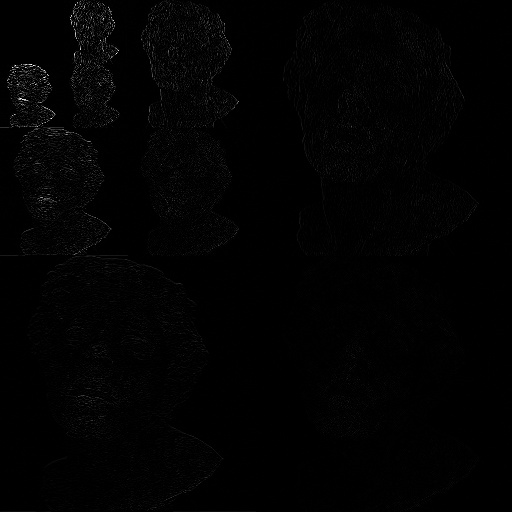

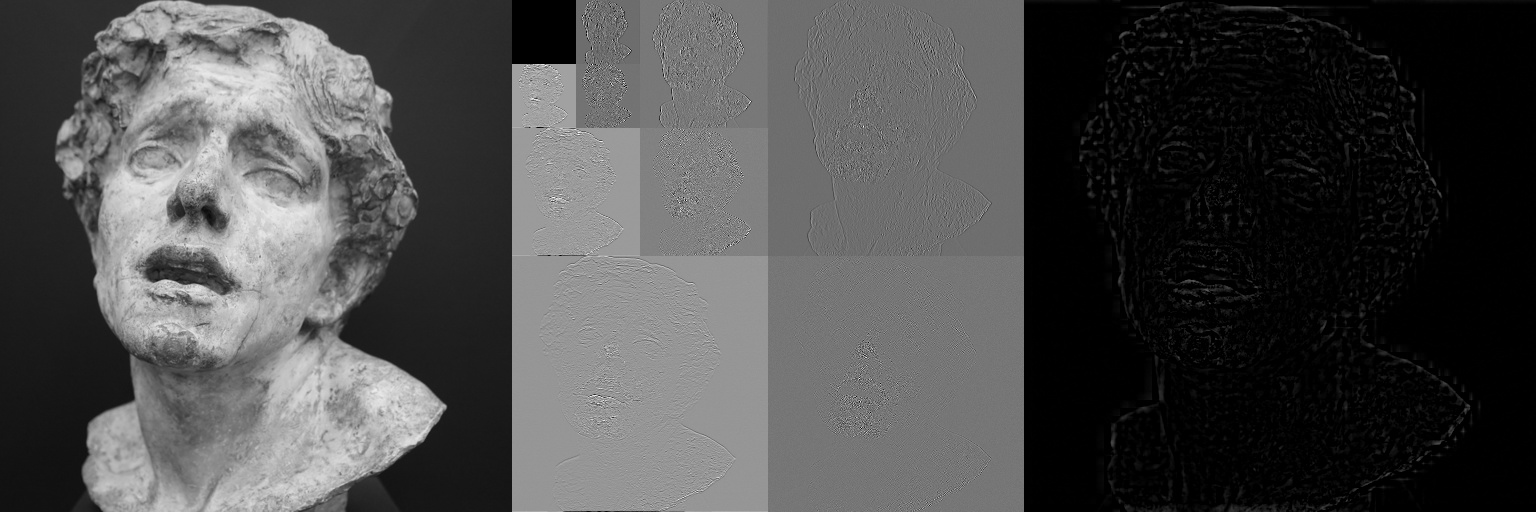

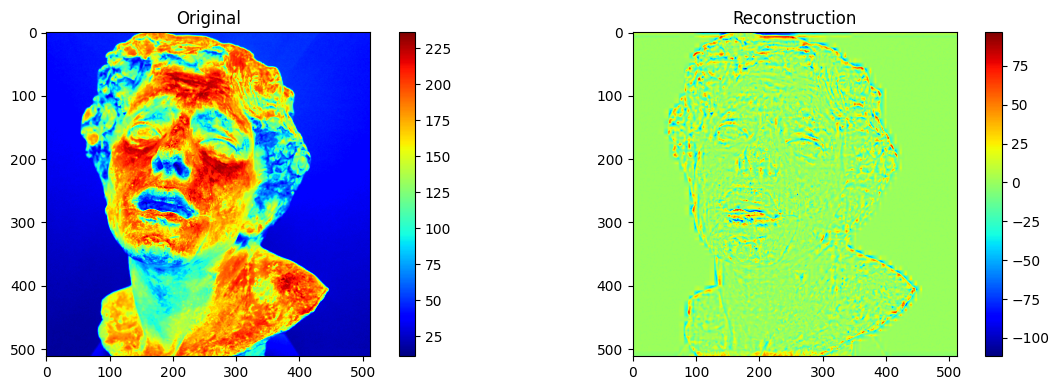

In [27]:
initial_time = time() 
array_photo = jpg_to_pgm(photo)
daubechies_4 = function_daubechies_coeffs(array_photo)
scale, width = 3, array_photo.shape[0]
result_img, normalized= daubechies4_wavelet_transform_2D(daubechies_4,array_photo,scale,width)

result_img = zeros(result_img, scale)
normalized = zeros(normalized, scale)

reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img,scale,width)
final_time = time()


execution_time = final_time - initial_time
print(execution_time)
imshow(result_img)
imshow(np.concatenate((array_photo, normalized, reconstructed), axis = 1))


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Mostrar cada imagen en un subplot diferente y agregar colorbar
im1 = axes[0].imshow(array_photo, cmap='jet')
axes[0].set_title('Original')
fig.colorbar(im1, ax=axes[0])

im3 = axes[1].imshow(reconstructed, cmap='jet')
axes[1].set_title('Reconstruction')
fig.colorbar(im3, ax=axes[1])
# Ajustar los espacios entre subplots
plt.tight_layout()
# Mostrar la figura
plt.show()



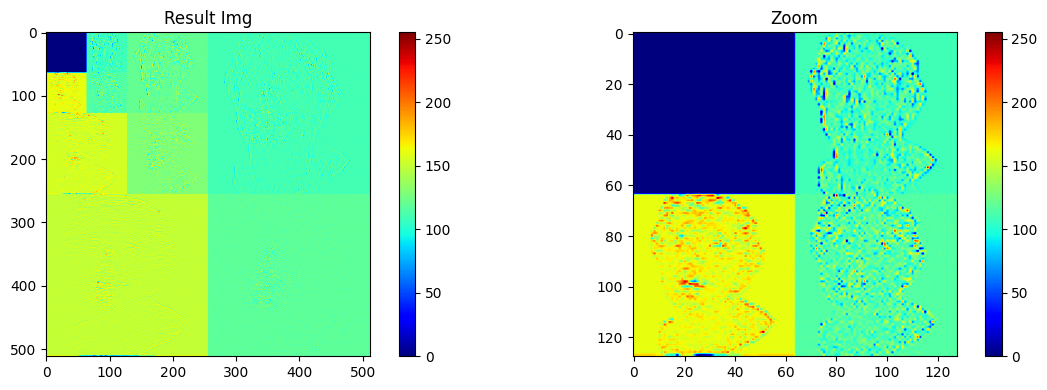

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
im1 = axes[0].imshow(normalized, cmap='jet')
axes[0].set_title('Result Img')
fig.colorbar(im1, ax=axes[0])

recortada = obtener_matriz_recortada(normalized,2)

im3 = axes[1].imshow(recortada, cmap='jet')
axes[1].set_title('Zoom')
fig.colorbar(im3, ax=axes[1])
# Ajustar los espacios entre subplots
plt.tight_layout()
# Mostrar la figura
plt.show()
